In [1]:
%load_ext autoreload

%autoreload 2

In [75]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow.keras as tfk
from sklearn.model_selection import train_test_split
from validation.metrics import OME, MSE
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, PowerTransformer
from MODELS.ViscNN import create_ViscNN, create_ViscNN_concat, create_ViscNN_phys, above_Mcr, Mcr_gpr_train, predict_all_cv, create_ViscNN_concat_HP
from validation.tests import viscNN_LC,get_Mw_samples, crossval_NN, Mw_test, evaluate_model, crossval_compare, get_shear_samples, shear_test
import keras_tuner as kt
from gpflow_tools.gpr_models import train_GPR, create_GPR
from data_tools.dim_red import fp_PCA
from data_tools.data_viz import val_epochs
import keras.backend as K
import keras
pd.options.mode.chained_assignment = None  # default='warn'

In [56]:
data = pd.read_excel('Data/full_data_2022-01-19_MOD.xlsx')
data.columns = [str(c) for c in data.columns]

In [57]:
shear_samps, shear_ids = get_shear_samples(data.copy())

In [58]:
Mw_samps, mw_ids = get_Mw_samples(data.copy()) 

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158

In [59]:
OG_fp = []
for c in data.columns:
    if isinstance(c, str):
        if 'fp' in c:
            OG_fp.append(c)
len(OG_fp)

217

In [60]:
do_pca = False
if do_pca:
    data, fp_cols, pca = fp_PCA(data, 17, cols = OG_fp)
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']
else:
    fp_cols = OG_fp
    cols = fp_cols + ['Mw', 'Temperature', 'Shear_Rate','Melt_Viscosity']

In [61]:
for c in ['Mw', 'Melt_Viscosity']:
    data[c] = np.log10(data[c])

data['ZERO_SHEAR'] = 1
data['SHEAR'] = 0
data['log_Shear_Rate'] = 0
for i in data.index:
    if data.loc[i, 'Shear_Rate'] != 0:
        data.loc[i,'log_Shear_Rate'] = np.log10(data.loc[i, 'Shear_Rate'])
        data.loc[i, 'SHEAR'] = 1
        data.loc[i, 'ZERO_SHEAR'] = 0
        #data = data.drop([i])

In [77]:
#cols.remove('Shear_Rate')
filtered_data = data.loc[:, cols + ['Polymer', 'SHEAR', 'ZERO_SHEAR', 'log_Shear_Rate']].dropna(subset = ['Mw', 'Shear_Rate'])
#X_tot = np.array(filtered_data.filter(fp_cols + ['SHEAR', 'ZERO_SHEAR']))
scaler = MinMaxScaler(copy = False)
X_tot = np.array(scaler.fit(filtered_data.filter(fp_cols)).transform(filtered_data.filter(fp_cols)))
tot_samples = X_tot.shape[0]
Y_tot = np.array(filtered_data.loc[:,'Melt_Viscosity']).reshape((tot_samples,1))

In [78]:
logMw = np.array(filtered_data['Mw']).reshape((tot_samples,1))
log_shear = np.array(filtered_data['log_Shear_Rate']).reshape((tot_samples,1))
shear = np.array(filtered_data['Shear_Rate']).reshape((tot_samples,1))
Temp = np.array(filtered_data['Temperature']).reshape((tot_samples,1))
Temp = 1/(Temp+273.15)

#y_scaler = MinMaxScaler(copy = False)
#y_scaler.fit(Y_tot).transform(Y_tot);
#S_scaler = MaxAbsScaler().fit(log_shear)
#log_shear = S_scaler.transform(log_shear)
T_scaler = MinMaxScaler().fit(Temp)
Temp = T_scaler.transform(Temp);
M_scaler = MinMaxScaler().fit(logMw)
logMw = M_scaler.transform(logMw);
S_trans = PowerTransformer(standardize = False).fit(shear)
S_scaler = MinMaxScaler().fit(S_trans.transform(shear))
shear = S_scaler.transform(S_trans.transform(shear))
#shear = S_scaler.transform((shear))
#gpr_Mcr, mcr_cv_error = Mcr_gpr_train(OG_fp, None, M_scaler, scaler, transform = False)

Learning Curve

Conducting test for train size 0.1
Conducting test for train size 0.2
Conducting test for train size 0.30000000000000004
Conducting test for train size 0.4
Conducting test for train size 0.5
Conducting test for train size 0.6
Conducting test for train size 0.7000000000000001
Conducting test for train size 0.9


([0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.0397828>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.1035428>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.1277835>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.1804404>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.1761172>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.1995947>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.1678288>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.2049925>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.1685243>],
 [<tf.Tensor: shape=(), dtype=float32, numpy=2.1213927>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.194737>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.1767685>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.1518588>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.1665447>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.1424792>,
  <tf.Tensor: shape=(), dtype=float32, numpy=2.1966956>,
  <tf.Ten

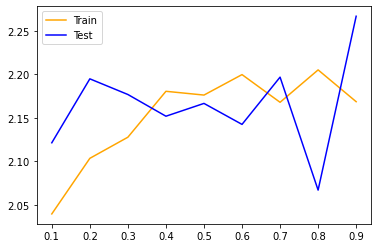

In [98]:
viscNN_LC(create_ViscNN_concat, X_tot, Y_tot,logMw, shear, Temp)

In [89]:
XX, X_test, yy, y_test, M, M_test, S, S_test, T, T_test, train_ind, test_ind = train_test_split(X_tot, Y_tot,logMw, shear, Temp, range(tot_samples), test_size= 0.1)

ValueError: test_size=0 should be either positive and smaller than the number of samples 1617 or a float in the (0, 1) range

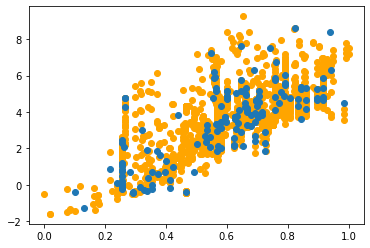

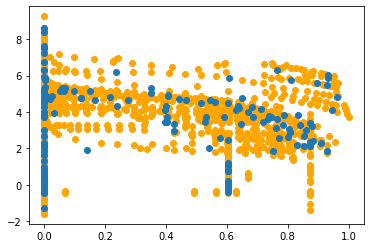

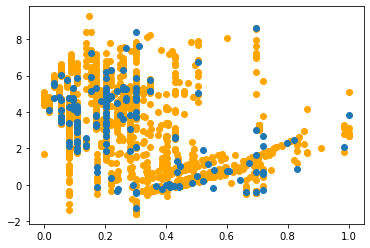

In [65]:
plt.scatter(M, yy, c = 'orange')
plt.scatter(M_test, y_test)

plt.figure()
plt.scatter(S, yy, c = 'orange')
plt.scatter(S_test, y_test)

plt.figure()
plt.scatter(T, yy, c = 'orange')
plt.scatter(T_test, y_test)

In [66]:
models, history, gpr_models, gp_cv  = crossval_compare([create_ViscNN_concat], XX, yy, M=M, S=S, T=T, S_trans = S_trans, S_scaler = S_scaler, M_scaler = M_scaler, verbose = 1, gpr_model = create_GPR, epochs = 600)

Trained fold 1 ...
CV Error create_ViscNN_concat: 0.20698288083076477
CV Error GPR: tf.Tensor(0.06393594, shape=(), dtype=float32)
Trained fold 2 ...
CV Error create_ViscNN_concat: 0.29781225323677063
CV Error GPR: tf.Tensor(0.1586553, shape=(), dtype=float32)
Trained fold 3 ...
CV Error create_ViscNN_concat: 0.28966009616851807
CV Error GPR: tf.Tensor(0.16319051, shape=(), dtype=float32)
Trained fold 4 ...
CV Error create_ViscNN_concat: 0.28840094804763794
CV Error GPR: tf.Tensor(0.1563214, shape=(), dtype=float32)
Trained fold 5 ...
CV Error create_ViscNN_concat: 0.24229112267494202
CV Error GPR: tf.Tensor(0.08769664, shape=(), dtype=float32)
Trained fold 6 ...
CV Error create_ViscNN_concat: 0.2766709327697754
CV Error GPR: tf.Tensor(0.16609995, shape=(), dtype=float32)
Trained fold 7 ...
CV Error create_ViscNN_concat: 0.26685217022895813
CV Error GPR: tf.Tensor(0.12934445, shape=(), dtype=float32)
Trained fold 8 ...
CV Error create_ViscNN_concat: 0.27865248918533325
CV Error GPR: tf

In [53]:
model_num = 4

Test OME:0.22493158


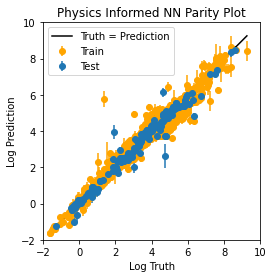

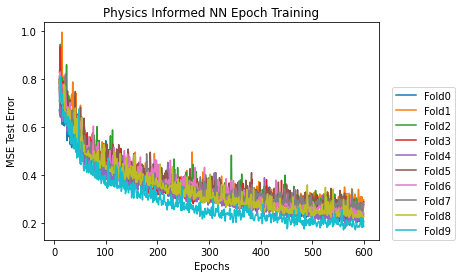

In [71]:
m_P = models[0][model_num]

test_pred, test_var,_ = predict_all_cv(models[0],[X_test, M_test, S_test, T_test])
train_pred, train_var,_ = predict_all_cv(models[0],[XX, M, S, T])
plt.errorbar(yy,train_pred, yerr = train_var, c = 'orange', fmt = 'o')
plt.errorbar(y_test ,test_pred, yerr= test_var, fmt =  'o')

plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(['Truth = Prediction','Train','Test'])
plt.title('Physics Informed NN Parity Plot')
val_epochs(history[0], name = 'Physics Informed NN')

print("Test OME:" + str(OME(np.array(test_pred),[y[0] for y in y_test]).numpy()))

In [246]:
m_P = models[0][model_num]

test_pred, test_var = predict_all_cv(models[0],[X_test, M_test, S_test, T_test])
train_pred, train_var = predict_all_cv(models[0],[XX, M, S, T])
plt.errorbar(yy,train_pred, yerr = train_var, c = 'orange', fmt = 'o')
plt.errorbar(y_test ,test_pred, yerr= test_var, fmt =  'o')

plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])
plt.title('Physics Informed NN Parity Plot')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.gca().set_aspect('equal', adjustable='box')
val_epochs(history[0], name = 'Physics Informed NN')

print("Test OME:" + str(OME(np.array(test_pred),[y[0] for y in y_test]).numpy()))

ValueError: too many values to unpack (expected 2)

In [41]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
train_df[train_df['BAD_PRED'] == True].sort_index().to_excel('NP_Bad_pred_1_19_2022.xlsx')

0.35321355791622044


In [411]:
m_P.summary()

Model: "model_148"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_641 (InputLayer)          [(None, 217)]        0                                            
__________________________________________________________________________________________________
input_643 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_645 (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_238 (Concatenate)   (None, 219)          0           input_641[0][0]                  
                                                                 input_643[0][0]          

IndexError: list index out of range

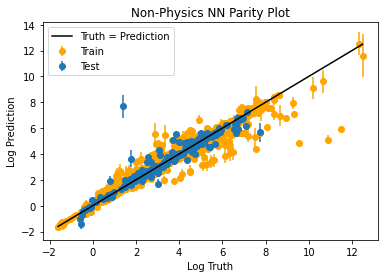

In [19]:
m_NP = models[0][model_num]
# test_pred =  m_NP.predict([X_test, M_test, S_test, T_test, gr_Mcr_test])
# train_pred = m_NP.predict([XX, M, S, T, gr_Mcr])
test_pred, test_var, _ = predict_all_cv(models[0],[X_test, M_test, S_test, T_test])
train_pred, train_var, _ = predict_all_cv(models[0],[XX, M, S, T])
#plt.scatter(yy, train_pred, c = 'orange')
#plt.scatter(y_test, test_pred)
plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-', zorder = 10)
plt.errorbar(yy,train_pred, yerr = train_var, c = 'orange', fmt = 'o')
plt.errorbar(y_test ,test_pred, yerr= test_var, fmt =  'o')


plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.legend(['Truth = Prediction','Train','Test'])
plt.title('Non-Physics NN Parity Plot')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.gca().set_aspect('equal', adjustable='box')
val_epochs(history[1], name = 'Non-Physics NN')

print("Test OME:" + str(OME(test_pred, [y[0] for y in y_test]).numpy()))


In [17]:
#gpr_model = train_GPR(XX, yy, M, S, T)
gpr_model = gpr_models[model_num]

Test MSE:0.2321288832750667
Test OME:tf.Tensor(0.14868426, shape=(), dtype=float32)
(158,)


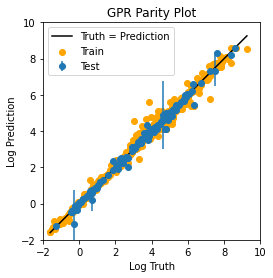

In [72]:
gpr_model = gpr_models[model_num] 
X_ = np.concatenate((X_test, M_test, S_test, T_test), axis = 1)
X_train = np.concatenate((XX, M, S, T), axis = 1)
test_pred, var = gpr_model.predict_y(X_)
## generate 10 samples from posterior
error =  [i[0] for i in np.array(var).tolist()]
print("Test MSE:" + str(MSE(test_pred, y_test)))
print("Test OME:" + str(OME(tf.cast(test_pred, tf.float32), y_test)))

high_var_test = np.where(np.array(var) > 10)
test_pred = np.delete(np.array(test_pred), high_var_test)
print(test_pred.shape)
y_test_new = np.delete(np.array(y_test), high_var_test)
var = np.delete(np.array(var), high_var_test)
# plt.plot(xx[:,0], samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
train_pred, var_train = gpr_model.predict_y(X_train)
plt.scatter(yy, train_pred, c = 'orange')
plt.errorbar(y_test_new, test_pred, var, fmt = 'o')
plt.ylabel('Log Prediction')
plt.xlabel('Log Truth')
plt.xlim(-2, 10)
plt.ylim(-2, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),np.linspace((min(yy)[0]), (max(yy)[0]), num = 2),'k-')
plt.legend(['Truth = Prediction', 'Train','Test'])
plt.title('GPR Parity Plot')
plt.show()

In [72]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
test_df[test_df['BAD_PRED'] == True]
test_df.reset_index().loc[error.index(max(error))]

ValueError: Length of values (152) does not match length of index (155)

In [67]:
train_df, test_df = evaluate_model(test_pred, train_pred , filtered_data, (train_ind, test_ind))
train_df[train_df['BAD_PRED'] == True]

0.34246501152543185


,afp_C4_C4_C4,afp_C4_C4_H1,afp_H1_C4_H1,bfp_267,bfp_282,bfp_289,bfp_304,bfp_315,bfp_334,bfp_349,...,Temperature,Shear_Rate,Melt_Viscosity,Polymer,SHEAR,ZERO_SHEAR,log_Shear_Rate,Y_pred,Error,BAD_PRED
1544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.493218,0.570096,...,260.0,935.307371,2.139073,"Poly(hexano-6-lactam), PPTA",1,0,2.970954,2.845784,0.706711,True
261,0.266667,0.466667,0.466667,0.533333,0.000000,0.200000,1.400000,0.000000,0.533333,0.533333,...,220.0,89.526571,4.423077,poly(methyl methacrylate),1,0,1.951952,3.929518,0.493559,True
1165,0.149429,0.448286,0.074714,0.000000,0.298857,0.224143,0.896571,0.149429,0.448286,0.489143,...,200.0,0.097696,4.552494,"polystyrene, polyacrylonitrile",1,0,-1.010123,4.170946,0.381547,True
1089,0.134643,0.403929,0.067321,0.000000,0.269286,0.201964,0.807857,0.134643,0.403929,0.495714,...,170.0,0.000000,3.214844,"polystyrene, polyacrylonitrile",0,1,0.000000,3.880512,0.665668,True
194,0.125000,0.375000,0.062500,0.000000,0.250000,0.187500,0.750000,0.125000,0.375000,0.500000,...,200.0,548.441658,2.209302,polystyrene,1,0,2.739130,2.872448,0.663145,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1100,0.181571,0.544714,0.090786,0.000000,0.363143,0.272357,1.089429,0.181571,0.544714,0.474857,...,200.0,0.390965,5.426735,"polystyrene, polyacrylonitrile",1,0,-0.407862,4.978222,0.448514,True
875,0.151515,0.484848,0.181818,0.000000,0.000000,0.545455,0.636364,0.000000,0.545455,0.363636,...,205.0,0.000000,3.399674,"poly[(2,2,3,3,4,4-hexafluoropentane-1,5-diol)-...",0,1,0.000000,3.810134,0.410461,True
183,0.333333,0.666667,0.166667,0.000000,0.000000,0.500000,1.000000,0.000000,0.666667,0.333333,...,210.0,0.000000,5.000000,poly(vinylidene fluoride),0,1,0.000000,5.585200,0.585200,True
1329,0.273810,0.821429,0.161905,0.033333,0.547619,0.410714,1.642857,0.273810,0.821429,0.435714,...,220.0,38.940893,3.532110,"polyacrylonitrile, Poly(methyl acrylate)",1,0,1.590406,4.012979,0.480869,True


In [331]:
tuner = kt.Hyperband(create_ViscNN_concat_HP, objective='val_loss',
                     max_epochs=20,
                     factor=3, project_name = 'create_ViscNN_concat1')

tuner.search([XX, M, S, T], yy,
             validation_data= ([X_test, M_test, S_test, T_test], y_test),
             epochs=20,
             batch_size = 16,
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

Trial 30 Complete [00h 00m 10s]
val_loss: 1.4985711574554443

Best val_loss So Far: 0.7200008630752563
Total elapsed time: 00h 03m 31s
INFO:tensorflow:Oracle triggered exit


In [332]:
tuner.get_best_hyperparameters(num_trials = 1)[0].values

{'layer_1': 120,
 'layer_2': 210,
 'layer_3': 150,
 'dropout_1': 0.1,
 'dropout_2': 0.30000000000000004,
 'dropout_3': 0.0,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [347]:
tuner = kt.Hyperband(
        create_ViscNN_concat_HP,
        objective='val_loss',
        max_epochs=400,
        seed=10,
        factor=3,
        hyperband_iterations=4,
        directory=f'hp_search',
        project_name= 'create_ViscNN_concat3'
        )

reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    factor=0.8,
    monitor="val_loss",
    verbose=1,
)
    
earlystop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)

# Create an instance of the model
tuner.search([XX, M, S, T], yy,
             validation_data= ([X_test, M_test, S_test, T_test], y_test),
            epochs=400,
            callbacks=[earlystop, reduce_lr],
            verbose=1
            )

Trial 670 Complete [00h 00m 15s]
val_loss: 0.5441340208053589

Best val_loss So Far: 0.4045839011669159
Total elapsed time: 00h 38m 27s

Search: Running Trial #671

Hyperparameter    |Value             |Best Value So Far 
layer_1           |210               |210               
layer_2           |150               |90                
dropout_1         |0                 |0.1               
dropout_2         |0                 |0                 
tuner/epochs      |400               |400               
tuner/initial_e...|134               |134               
tuner/bracket     |3                 |5                 
tuner/round       |3                 |5                 
tuner/trial_id    |1d5994880029b6b...|91e9e38aeda1897...

Epoch 135/400
44/44 [==============================] - 0s 5ms/step - loss: 4.9007 - val_loss: 3.2113
Epoch 136/400
44/44 [==============================] - 0s 3ms/step - loss: 2.6957 - val_loss: 2.4868
Epoch 137/400
44/44 [==============================] - 0s 3ms/

KeyboardInterrupt: 

In [95]:
k_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('log_k_1').output)
tau_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('tau').output)
alpha_layer = params_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('alpha').output)
n_layer = params_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('n').output)
crit_shear_layer = params_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer('crit_shear').output)
layer_name2 = 'zero_shear_visc'
z_shear_layer = keras.Model(inputs=m_P.input,
                                       outputs=m_P.get_layer(layer_name2).output)

ValueError: No such layer: log_k_1.

In [283]:
extrap_tests = Mw_test(Mw_samps, mw_ids[6])

    INDEX  SAMPLE_ID          SMILES          Polymer            Mn        Mw  \
0      56        8.0  [*]CC([*])(C)C  polyisobutylene  2.454545e+04  4.431364   
1      57        8.0  [*]CC([*])(C)C  polyisobutylene  5.614035e+04  4.806180   
2      58        8.0  [*]CC([*])(C)C  polyisobutylene  8.925620e+04  5.033424   
3      59        8.0  [*]CC([*])(C)C  polyisobutylene  1.104348e+05  5.103804   
4      60        8.0  [*]CC([*])(C)C  polyisobutylene  1.141593e+05  5.110590   
5      61        8.0  [*]CC([*])(C)C  polyisobutylene  1.198198e+05  5.123852   
6      62        8.0  [*]CC([*])(C)C  polyisobutylene  1.380165e+05  5.222716   
7      63        8.0  [*]CC([*])(C)C  polyisobutylene  1.145078e+05  5.344392   
8      64        8.0  [*]CC([*])(C)C  polyisobutylene  2.372263e+05  5.511883   
9      65        8.0  [*]CC([*])(C)C  polyisobutylene  2.519084e+05  5.518514   
10     66        8.0  [*]CC([*])(C)C  polyisobutylene  1.683673e+05  5.518514   
11     67        8.0  [*]CC(

In [284]:
XX_ex, OH, M_ex_og,S_ex_og,T_ex = extrap_tests['data_in']
#print(extrap_tests[samp_num]['tests'])
Mw_ex = extrap_tests['exp'][0]
log_visc_ex = extrap_tests['exp'][1]
#XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform((XX_ex))
M_ex = M_scaler.transform(M_ex_og)
S_ex = S_scaler.transform(S_trans.transform(S_ex_og)) #(
T_ex = T_scaler.transform(1/(T_ex+273.15))

Text(0.5, 1.0, 'GPR Extrapolation')

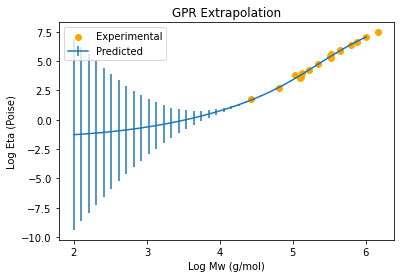

In [285]:
test_pred, var = gpr_model.predict_y(np.concatenate((XX_ex, M_ex, S_ex, T_ex), axis = 1))
plt.figure()
plt.xlabel('Log Mw (g/mol)')
plt.ylabel('Log Eta (Poise)')
plt.y_lim(-3, 10)

plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
#plt.scatter(M_scaler.inverse_transform(M_ex), test_pred)
plt.errorbar(M_scaler.inverse_transform(M_ex), test_pred, [i[0] for i in np.array(var).tolist()], fmt = '-')
plt.legend(['Experimental','Predicted'])
plt.title('GPR Extrapolation')

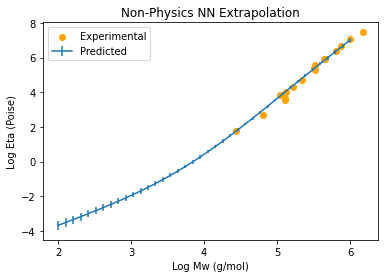

In [286]:
#test_pred = m_NP.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])
test_pred, test_var,_ = predict_all_cv(models[0],[XX_ex, M_ex, S_ex, T_ex])

plt.figure()
plt.title('Non-Physics NN Extrapolation')
plt.xlabel('Log Mw (g/mol)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
plt.y_lim(-3, 10)
#plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var)
plt.legend(['Experimental','Predicted'])

NameError: name 'k_layer' is not defined

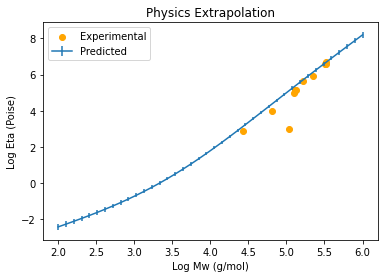

In [274]:
#test_pred = m_P.predict([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex])
test_pred, test_var, tot_pred = predict_all_cv(models[0],[XX_ex, M_ex, S_ex, T_ex])
plt.figure()
plt.title('Physics Extrapolation')
plt.xlabel('Log Mw (g/mol)')
plt.ylabel('Log Eta (Poise)')
plt.errorbar(M_scaler.inverse_transform(M_ex),test_pred, yerr= test_var)
plt.scatter(Mw_ex, log_visc_ex, c = 'orange')
plt.plot(M_scaler.inverse_transform(M_ex), test_pred)
plt.y_lim(-3, 10)
plt.legend(['Experimental','Predicted'])
#plt.plot([4,6], [2.5, 2.5+(3.4*2)])
print(k_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
print(tau_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
print(alpha_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))
print(n_layer([XX_ex, M_ex, S_ex, T_ex, gr_Mcr_ex]))

In [326]:
samp_num = shear_ids[6]
s_test = shear_test(shear_samps, samp_num);
XX_ex, M_ex,S_ex,T_ex = s_test['data_in']
shear_exp = s_test['known'][0]
log_visc_exp = s_test['known'][1]
#XX_OH_ex = scaler.transform(np.concatenate((pca.transform(XX_ex), OH), axis = 1))
XX_ex = scaler.transform((pca.transform(XX_ex))) if do_pca else scaler.transform(((XX_ex)))
M_ex = M_scaler.transform(M_ex)
S_ex_trans = S_scaler.transform(S_trans.transform(S_ex))
T_ex = T_scaler.transform(1/(T_ex+273.15))
temp_test = False

    INDEX  SAMPLE_ID             SMILES                    Polymer  Mn  \
0     362        7.0  [*]Sc1ccc([*])cc1  poly(p-phenylene sulfide) NaN   
1     363        7.0  [*]Sc1ccc([*])cc1  poly(p-phenylene sulfide) NaN   
2     364        7.0  [*]Sc1ccc([*])cc1  poly(p-phenylene sulfide) NaN   
3     365        7.0  [*]Sc1ccc([*])cc1  poly(p-phenylene sulfide) NaN   
4     366        7.0  [*]Sc1ccc([*])cc1  poly(p-phenylene sulfide) NaN   
5     367        7.0  [*]Sc1ccc([*])cc1  poly(p-phenylene sulfide) NaN   
6     368        7.0  [*]Sc1ccc([*])cc1  poly(p-phenylene sulfide) NaN   
7     369        7.0  [*]Sc1ccc([*])cc1  poly(p-phenylene sulfide) NaN   
8     370        7.0  [*]Sc1ccc([*])cc1  poly(p-phenylene sulfide) NaN   
9     371        7.0  [*]Sc1ccc([*])cc1  poly(p-phenylene sulfide) NaN   
10    372        7.0  [*]Sc1ccc([*])cc1  poly(p-phenylene sulfide) NaN   

         Mw  PDI  PDI (zw)  Temperature  Shear_Rate  ...  bfp_79 bfp_210  \
0   4.80618  NaN       NaN        3

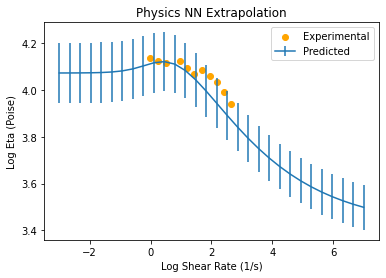

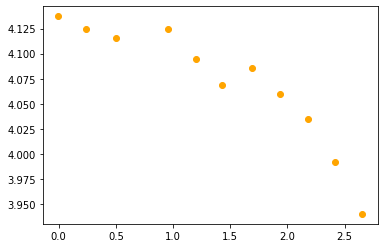

In [327]:
#test_pred = m_P.predict([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex])
test_pred, test_var,_ = predict_all_cv(models[0],[XX_ex, M_ex, S_ex_trans, T_ex])
shear = [s[0] for s in np.log10(S_ex)]

plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
if temp_test:
    for i in [1,3,5]:
        test_pred, test_var = predict_all_cv(models[0],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]])])
        plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Log Shear Rate (1/s)')
plt.ylabel('Log Eta (Poise)')
plt.scatter(shear_exp, log_visc_exp, c = 'orange')
#plt.plot(np.log10(S_ex[:-1]), test_pred[:-1])
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Predication at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
     plt.legend(['Experimental','Predicted'])
plt.title('Physics NN Extrapolation')


plt.figure()
plt.scatter(shear_exp, log_visc_exp, c = 'orange')

#print(params_layer([XX_ex, M_ex, S_ex_trans, T_ex]))
#z_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex])
#print(crit_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(tau_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(n_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))
#print(z_shear_layer([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex]))

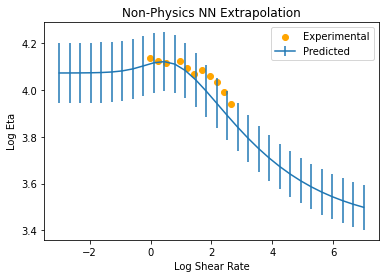

In [328]:
#test_pred = m_NP.predict([XX_ex, M_ex, S_ex_trans, T_ex, gr_Mcr_ex])
test_pred, test_var,_ = predict_all_cv(models[0], [XX_ex, M_ex, S_ex_trans, T_ex])
shear = [s[0] for s in np.log10(S_ex)]

plt.figure()
plt.errorbar(shear, test_pred, yerr= test_var)
plt.title('Non-Physics NN Extrapolation')

if temp_test:
    for i in [1,3,5]:
        test_pred, test_var = predict_all_cv(models[1],[XX_ex, M_ex, S_ex_trans, T_ex +T_scaler.transform([[10*i]]), gr_Mcr_ex])
        plt.errorbar(shear, test_pred, yerr= test_var)
plt.xlabel('Log Shear Rate')
plt.ylabel('Log Eta')
plt.scatter(shear_exp, log_visc_exp, c = 'orange')
if temp_test:
    plt.legend(['Experimental','Predicted'] + ['Prediction at ' + str(T_scaler.inverse_transform(T_ex)[0] + 10*i) + 'C' for i in [1,3,5]])
else:
    plt.legend(['Experimental','Predicted'])
#plt.plot(np.log10(S_ex), test_pred)

[0.046294077696831096, 0.04625179078585913, 0.04616047674987496, 0.04596911811124767, 0.04559494166448215, 0.04497829689528683, 0.04438321509433803, 0.04493580851375907, 0.04701008015233239, 0.04624647786819065, 0.043379830942995426, 0.04142732436219217, 0.04012732076797161, 0.04000105131590399, 0.0395182163996098, 0.03896361490995599, 0.040056382122315284, 0.052152458032352314, 0.0891811578732374, 0.15882414177878995, 0.2600034552522062, 0.38613745736171917, 0.528720199486329, 0.6795930386275829, 0.8319954002276754, 0.9808463806656315, 1.1226352151856276, 1.2551560547385556, 1.3772121068847831, 1.4883462825374025]


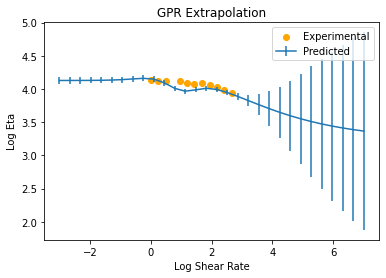

In [329]:
test_pred, test_var = gpr_model.predict_y(np.concatenate((XX_ex, M_ex, S_ex_trans, T_ex), axis = 1))
plt.figure()
plt.title('GPR Extrapolation')
plt.errorbar(shear, test_pred, yerr= [i[0] for i in np.array(test_var).tolist()])
plt.xlabel('Log Shear Rate')
plt.ylabel('Log Eta')
plt.scatter(shear_exp, log_visc_exp, c = 'orange')
print([i[0] for i in np.array(test_var).tolist()])
plt.legend(['Experimental','Predicted'])

START TRAINING GPR FOR Mcr

In [94]:
me_data = pd.read_excel('Data/EntanglementMW_fp.xlsx')
fp = me_data[[c for c in me_data.columns if 'fp' in c]]
fp[[c for c in OG_fp if c not in fp]] = 0
fp = fp.drop(columns = [c for c in fp if c not in OG_fp])
y = M_scaler.transform(np.log10(np.array(me_data['Me']*2)).reshape(-1,1))
X_me = scaler.transform((pca.transform(fp[OG_fp]))) if do_pca else scaler.transform(((fp[OG_fp])))

C:\Users\ayush\Documents\Melt_Viscosity\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [95]:
x_me, x_me_test, y_me, y_me_test = train_test_split(X_me, y, test_size = 0.1)

In [96]:
gpr_Mcr = create_GPR(X_me, y)

In [17]:
tf.saved_model.save(gpr_Mcr, 'models')

Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


Instructions for updating:
`min_event_ndims` is now static for all bijectors; this property is no longer needed.


INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


In [18]:
gpr = tf.saved_model.load('models')

In [ ]:
gpr.predict_y(x_me)

In [24]:
trial_scale = MinMaxScaler(copy = False)

In [25]:
arr = np.array([[1,1,1], [1,2,3]])

In [26]:
trial_scale.fit(arr).transform(arr)

array([[0., 0., 0.],
       [0., 1., 1.]])